In [1]:
import pofah.jet_sample as js
import pofah.util.sample_factory as sf
import pofah.util.experiment as ex
import selection.discriminator as dis
import selection.loss_strategy as ls
import analysis.analysis_discriminator as an
import anpofah.util.plotting_util as pu
import datetime

Welcome to JupyROOT 6.18/04


In [2]:
# read in qcd signal region sample
run_n = 101
SM_sample = 'qcdSigReco'
BSM_samples = ['GtoWW15naReco', 'GtoWW15brReco', 'GtoWW25naReco', 'GtoWW25brReco','GtoWW35naReco', 'GtoWW35brReco', 'GtoWW45naReco', 'GtoWW45brReco']
#BSM_samples = ['GtoWW25naReco', 'GtoWW35naReco', 'GtoWW45naReco']
all_samples = [SM_sample] + BSM_samples
mjj_key = 'mJJ'
reco_loss_j1_key = 'j1RecoLoss'
QR_train_share = 0.20

In [3]:
experiment = ex.Experiment(run_n).setup(analysis_dir=True)
sig_data = sf.read_results_to_jet_sample_dict(all_samples, experiment)

split into discriminator train and test-set

In [4]:
# define quantile and loss-strategy for discimination
quantile = 0.05 # 5%
strategy = ls.combine_loss_min
qcd_sig_sample = sig_data[SM_sample]
#split qcd sample into training and testing
qcd_train, qcd_test = js.split_jet_sample_train_test(qcd_sig_sample, QR_train_share)
# update data_dictionary
sig_data[SM_sample] = qcd_test

In [5]:
print(qcd_sig_sample.features())
# train discriminator (and plot results => TODO)
discriminator = dis.QRDiscriminator(quantile=quantile, loss_strategy=strategy)
discriminator.fit(qcd_train)

W0813 10:19:55.997421 139625441883968 deprecation.py:506] From /cvmfs/sft.cern.ch/lcg/views/LCG_96bpython3/x86_64-centos7-gcc9-opt/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']


W0813 10:19:56.292873 139625441883968 deprecation.py:323] From /eos/home-k/kiwoznia/dev/data_driven_anomaly_hunting/dadrah/selection/quantile_regression.py:14: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_______________________________________________________________

2020-08-13 10:19:56.685004: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-08-13 10:19:56.710270: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199945000 Hz
2020-08-13 10:19:56.717566: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8c913b0 executing computations on platform Host. Devices:
2020-08-13 10:19:56.717591: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2020-08-13 10:19:56.787431: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

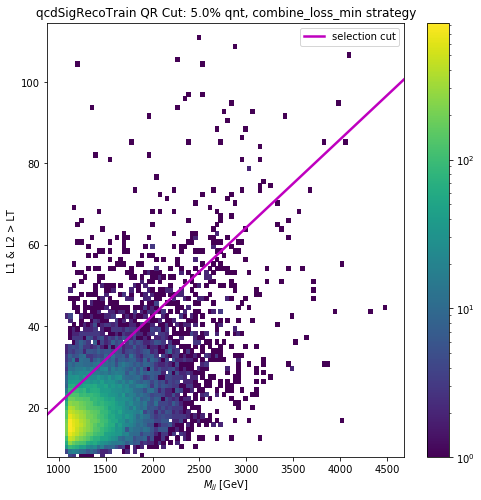

In [6]:
# plot mjj qcd sig to check for flat ratio
an.analyze_discriminator_cut(discriminator, qcd_train)

In [7]:
date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
model_str = str(QR_train_share)+'_qr_train_'+ str(quantile) +'q_'+ date_str
discriminator.save('models/dnn_run_101_{}.h5'.format(model_str))

## plot mjj accepted vs rejected signal to check for mass sculpting

In [8]:
Mjj_selection = 1100.

In [14]:
sample = sig_data[SM_sample]
# apply selection to datasample
selection = discriminator.select(sample)
#qcd_sig_test_selected = discriminator.apply(qcd_sig_test)
sample.add_feature('sel', selection)

Info in <TCanvas::Print>: png file /eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101/qcdSigRecoTest_mjj_hist_ratio.png has been created


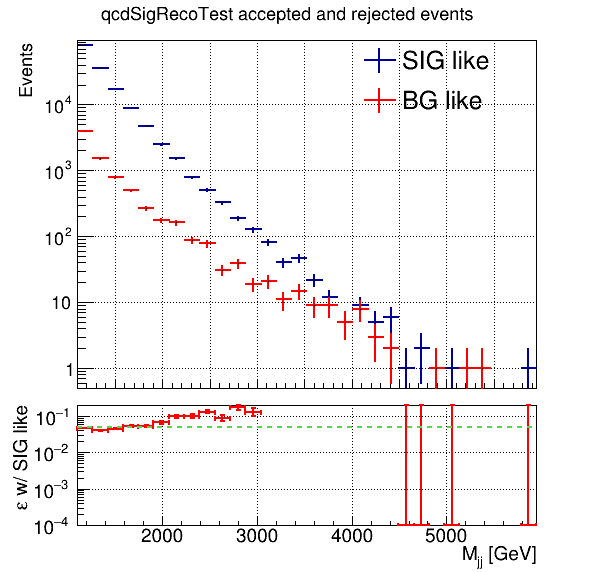

In [15]:
binning=[30, Mjj_selection, sample[mjj_key].max()]
an.plot_mass_spectrum_ratio(sample.accepted(mjj_key), sample.rejected(mjj_key), binning, quantile, sample.name +' accepted and rejected events', fig_dir=experiment.analysis_dir, plot_name=sample.plot_name()+'_mjj_hist_ratio.png')

# Calling ratio plot 2nd time makes kernel crash!

In [ ]:
sample = sig_data[SM_sample]
# apply selection to datasample
selection = discriminator.select(sample)
#qcd_sig_test_selected = discriminator.apply(qcd_sig_test)
sample.add_feature('sel', selection)

binning=[30, Mjj_selection, sample[mjj_key].max()]
an.plot_mass_spectrum_ratio(sample.accepted(mjj_key), sample.rejected(mjj_key), binning, quantile, sample.name +' accepted and rejected events', fig_dir=experiment.analysis_dir, plot_name=sample.plot_name()+'_mjj_hist_ratio.png')

# apply selection

In [10]:
for sample in BSM_samples:
    # apply selection to datasample
    selection = discriminator.select(sig_data[sample])
    #qcd_sig_test_selected = discriminator.apply(qcd_sig_test)
    sig_data[sample].add_feature('sel', selection)

## plot losses (reco vs kl) for accepted and rejected sample

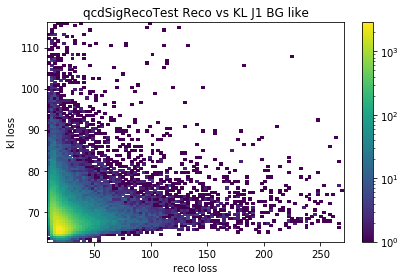

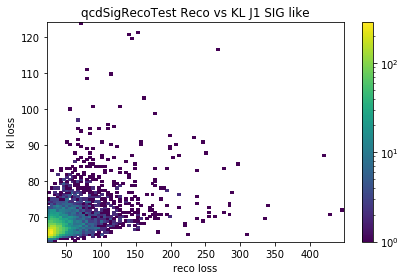

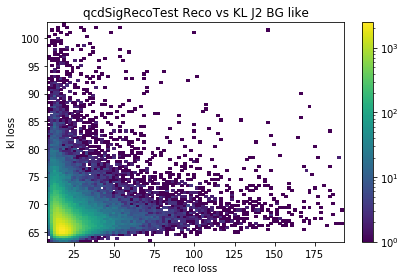

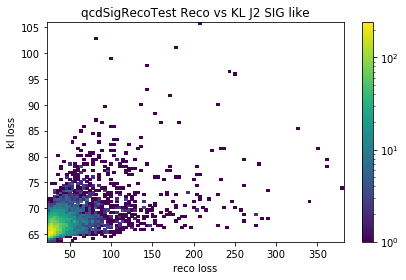

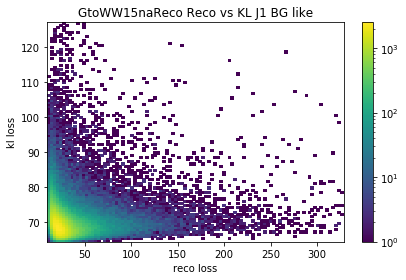

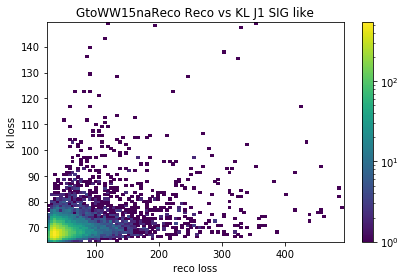

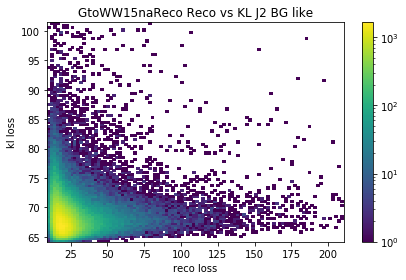

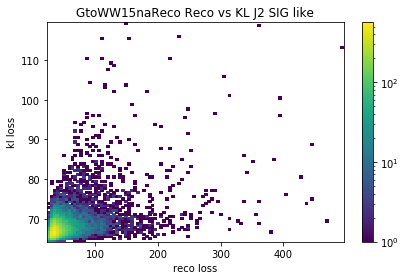

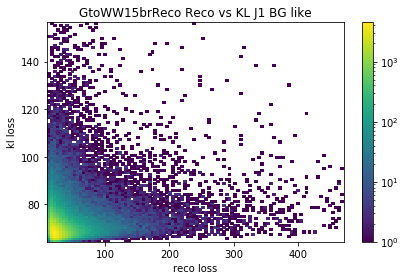

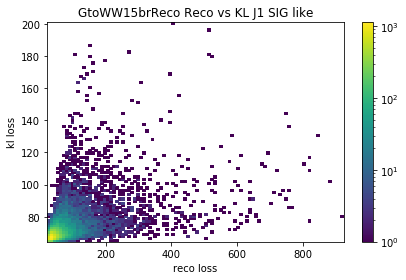

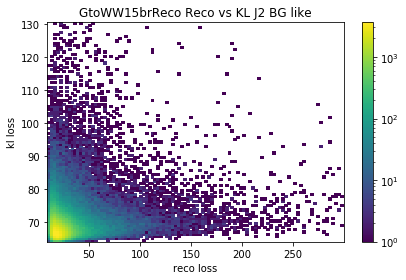

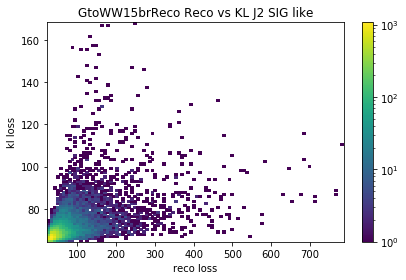

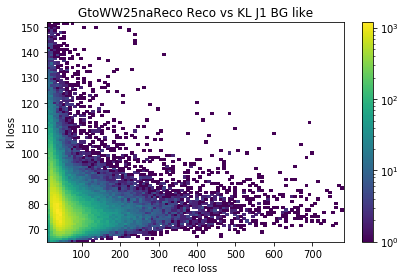

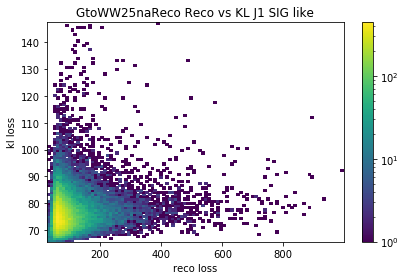

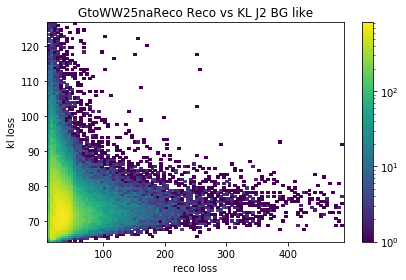

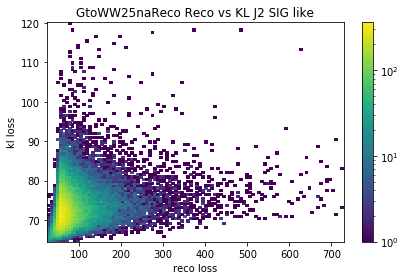

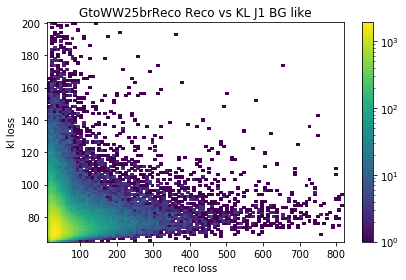

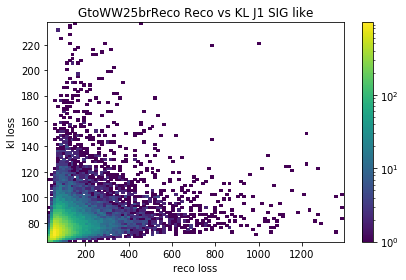

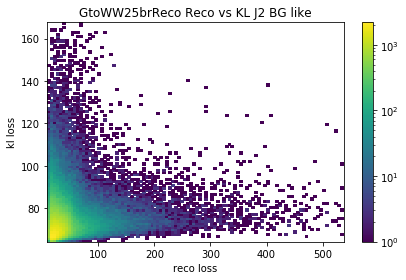

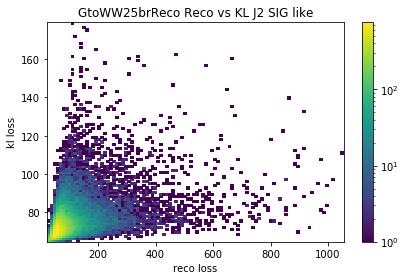

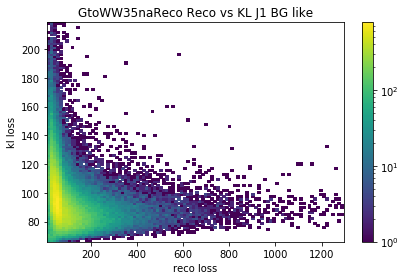

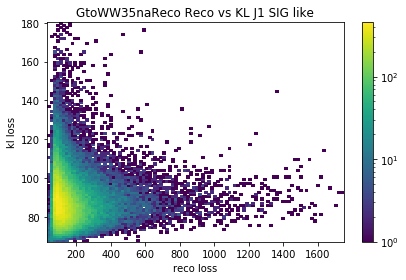

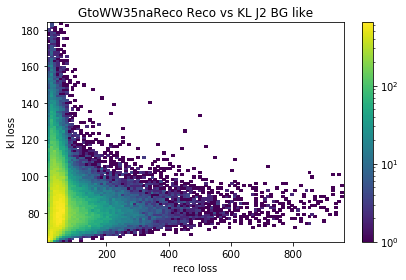

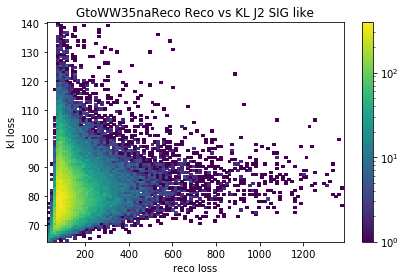

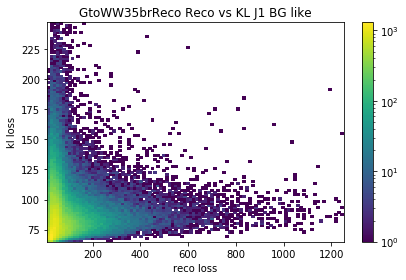

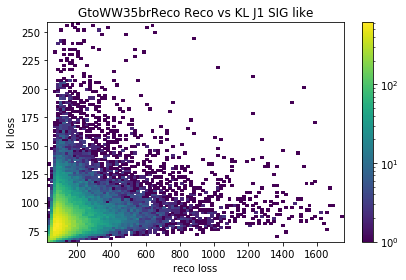

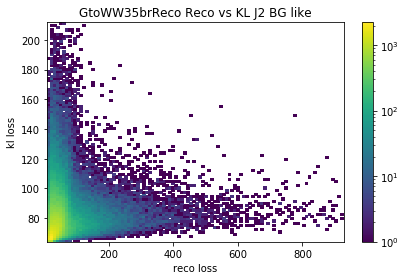

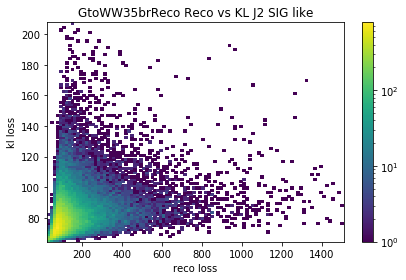

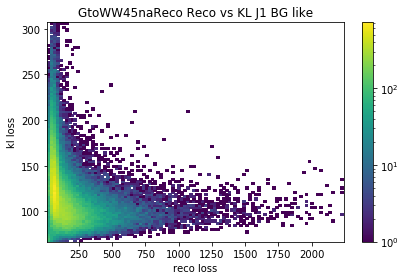

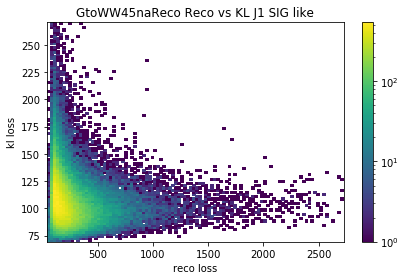

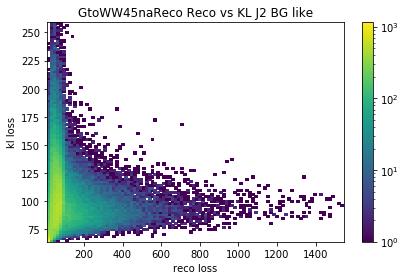

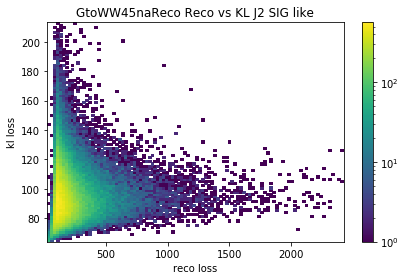

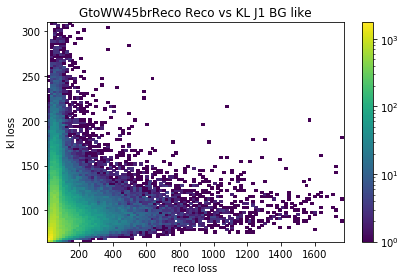

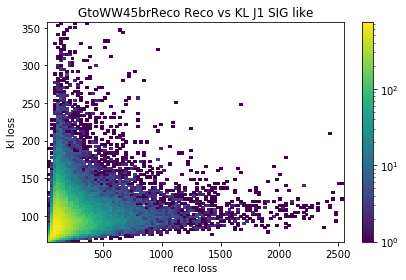

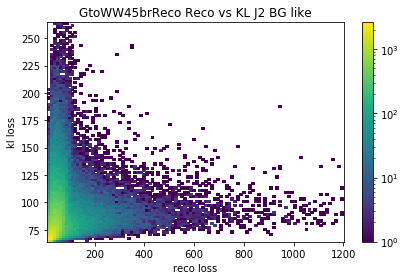

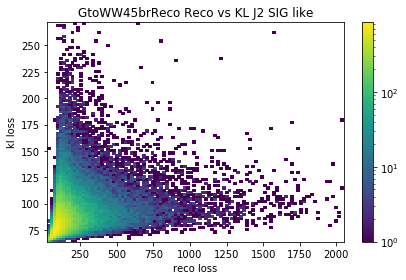

In [13]:
for sample in sig_data.values():
    # plot BG like J1
    pu.plot_hist_2d(sample.rejected('j1RecoLoss'),sample.rejected('j1KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J1 BG like', clip_outlier=True, fig_dir=experiment.analysis_dir, plot_name=sample.plot_name()+'_RecoVsKLJ1_BGlike.png')
    # plot SIG like J1
    pu.plot_hist_2d(sample.accepted('j1RecoLoss'),sample.accepted('j1KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J1 SIG like', clip_outlier=True, fig_dir=experiment.analysis_dir, plot_name=sample.plot_name()+'_RecoVsKLJ1_SIGlike.png')
    # plot BG like J2
    pu.plot_hist_2d(sample.rejected('j2RecoLoss'),sample.rejected('j2KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J2 BG like', clip_outlier=True, fig_dir=experiment.analysis_dir, plot_name=sample.plot_name()+'_RecoVsKLJ2_BGlike.png')
    # plot SIG like J1
    pu.plot_hist_2d(sample.accepted('j2RecoLoss'),sample.accepted('j2KlLoss'), xlabel='reco loss', ylabel='kl loss', title=sample.name+' Reco vs KL J2 SIG like', clip_outlier=True, fig_dir=experiment.analysis_dir, plot_name=sample.plot_name()+'_RecoVsKLJ2_SIGlike.png')
    

In [12]:
print(experiment.analysis_dir)

/eos/home-k/kiwoznia/data/VAE_results/bump_hunt_results/run_101
